# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os
from matplotlib.image import imread
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, MaxPool2D, Activation, Dropout,  Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from skimage.segmentation import mark_boundaries
from PIL import Image
import lime
from lime import lime_image

# DATA GATHERING AND PREPARATION

In [2]:
#load the image directories for training, testing, and predictions
train_dir = "C:/Users/muell/COE 005/Midterm/Practice Exercise/Covid19-dataset/train"
test_dir = "C:/Users/muell/COE 005/Midterm/Practice Exercise/Covid19-dataset/test"
data_path = 'C:/Users/muell/COE 005/Midterm/Practice Exercise/Covid19-dataset/validation'
os.listdir(train_dir)

['Covid', 'Normal', 'Viral Pneumonia']

In [3]:
#We use categorical in class_mode for more than 2 classes of images
train_data = ImageDataGenerator(rescale = 1./255,zoom_range = 0.2,rotation_range=15,horizontal_flip = True)
test_data = ImageDataGenerator(rescale = 1./255)
train_set = train_data.flow_from_directory(train_dir,target_size = (224, 224),batch_size = 16,
class_mode = 'categorical',
shuffle=True)
test_set = test_data.flow_from_directory(test_dir,target_size = (224, 224),batch_size = 16,
class_mode = 'categorical',
shuffle = False)

Found 249 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


# DEFINE CNN MODEL

In [4]:
#Resize the image for input
image_size = (224,224,3)
#Define the model
model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu", input_shape = image_size))
model.add(MaxPool2D())

model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 256,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 512,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))
#Last layer has 3 outputs as classes.
model.add(Dense(3, activation = "softmax"))

#Compile the model
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# TRAINING THE MODEL

In [5]:
#train the model
history = model.fit(train_set, validation_data=test_set,steps_per_epoch=16,epochs=80)

Epoch 1/80
16/16 [==============================] - 31s 2s/step - loss: 1.3123 - accuracy: 0.3655 - val_loss: 1.1014 - val_accuracy: 0.3846
Epoch 2/80
16/16 [==============================] - 30s 2s/step - loss: 1.0725 - accuracy: 0.4578 - val_loss: 1.0365 - val_accuracy: 0.3846
Epoch 3/80
16/16 [==============================] - 30s 2s/step - loss: 0.7654 - accuracy: 0.5944 - val_loss: 0.8444 - val_accuracy: 0.6154
Epoch 4/80
16/16 [==============================] - 30s 2s/step - loss: 0.7474 - accuracy: 0.7108 - val_loss: 0.6659 - val_accuracy: 0.6923
Epoch 5/80
16/16 [==============================] - 29s 2s/step - loss: 0.5103 - accuracy: 0.7671 - val_loss: 0.5464 - val_accuracy: 0.7077
Epoch 6/80
16/16 [==============================] - 30s 2s/step - loss: 0.4668 - accuracy: 0.8554 - val_loss: 0.8486 - val_accuracy: 0.6308
Epoch 7/80
16/16 [==============================] - 30s 2s/step - loss: 0.5044 - accuracy: 0.7871 - val_loss: 0.5577 - val_accuracy: 0.8154
Epoch 8/80
16/16 [==

16/16 [==============================] - 31s 2s/step - loss: 0.2285 - accuracy: 0.9197 - val_loss: 0.1970 - val_accuracy: 0.9385
Epoch 60/80
16/16 [==============================] - 31s 2s/step - loss: 0.1534 - accuracy: 0.9478 - val_loss: 0.3117 - val_accuracy: 0.8923
Epoch 61/80
16/16 [==============================] - 31s 2s/step - loss: 0.1386 - accuracy: 0.9518 - val_loss: 0.2238 - val_accuracy: 0.9231
Epoch 62/80
16/16 [==============================] - 31s 2s/step - loss: 0.1736 - accuracy: 0.9357 - val_loss: 0.3507 - val_accuracy: 0.9077
Epoch 63/80
16/16 [==============================] - 31s 2s/step - loss: 0.1402 - accuracy: 0.9357 - val_loss: 0.3889 - val_accuracy: 0.8769
Epoch 64/80
16/16 [==============================] - 31s 2s/step - loss: 0.1571 - accuracy: 0.9398 - val_loss: 0.2991 - val_accuracy: 0.9231
Epoch 65/80
16/16 [==============================] - 31s 2s/step - loss: 0.1671 - accuracy: 0.9438 - val_loss: 0.6205 - val_accuracy: 0.8154
Epoch 66/80
16/16 [======

# MODEL EVALUATION

In [6]:
#training and testing accuracy
print("training_accuracy", history.history['accuracy'][-1])
print("testing_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9518072009086609
testing_accuracy 0.8615384697914124


<AxesSubplot:>

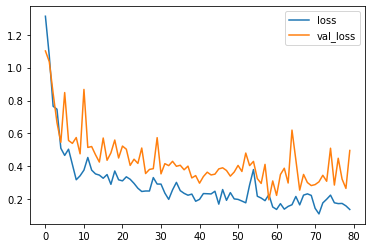

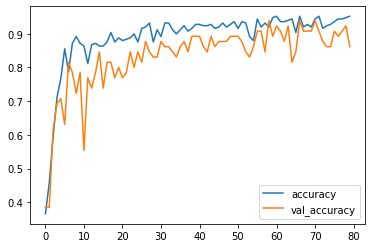

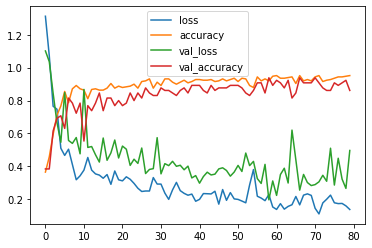

In [7]:
#loss accuracy per epochs
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()
losses.plot()

In [8]:
#save the model for prediction
model.save('covid_model.h5')

5/5 [==============================] - 3s 439ms/step


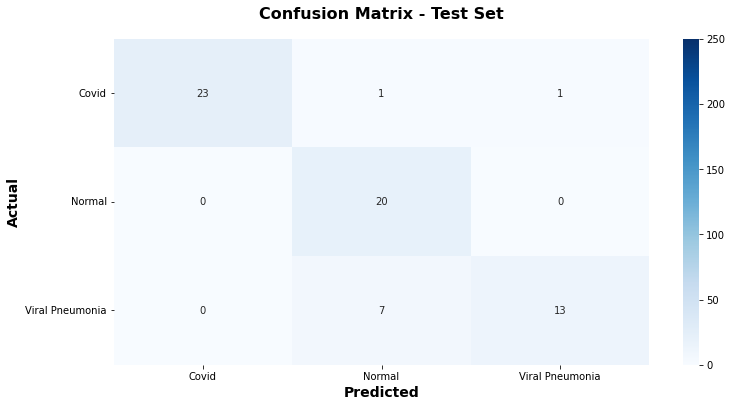

In [9]:
#Confusion matrix for visualization of prediction accuracy
classes = ["Covid", "Normal", "Viral Pneumonia"]

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [10]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.71      1.00      0.83        20
           2       0.93      0.65      0.76        20

    accuracy                           0.86        65
   macro avg       0.88      0.86      0.85        65
weighted avg       0.89      0.86      0.86        65



In [11]:
#define a dictionary for 3 outputs
class_dict = {0:'Covid',1:'Normal',2:'Viral Pneumonia'}

# PREDICTIONS

1/1 [==============================] - 0s 166ms/step
prediction:  Covid


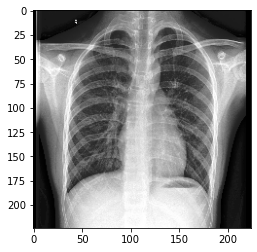

In [12]:
#PIC 1 PREDICTION
file_path = '/pic1.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 70ms/step
prediction:  Covid


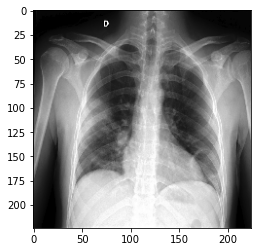

In [13]:
#PIC 2 PREDICTION
file_path = '/pic2.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 69ms/step
prediction:  Covid


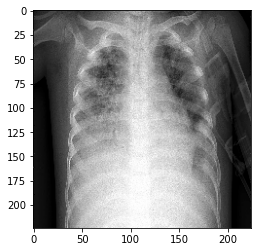

In [14]:
#PIC 3 PREDICTION
file_path = '/pic3.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 67ms/step
prediction:  Viral Pneumonia


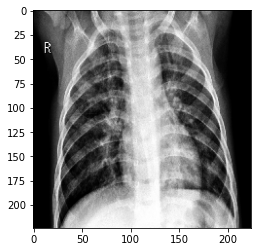

In [15]:
#PIC 4 PREDICTION
file_path = '/pic4.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 68ms/step
prediction:  Normal


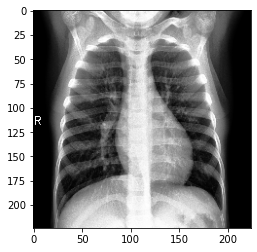

In [16]:
#PIC 5 PREDICTION
file_path = '/pic5.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 73ms/step
prediction:  Covid


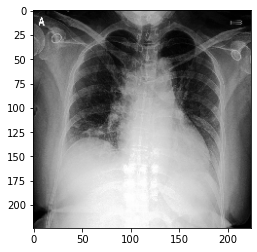

In [17]:
#PIC 6 PREDICTION
file_path = '/pic6.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 76ms/step
prediction:  Covid


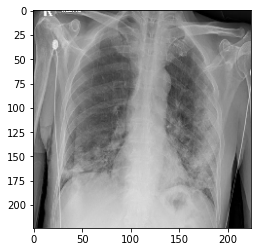

In [18]:
#PIC 7 PREDICTION
file_path = '/pic7.jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 67ms/step
prediction:  Viral Pneumonia


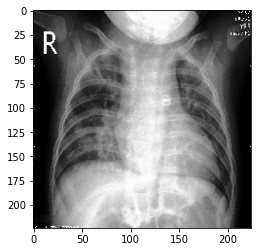

In [19]:
#PIC 8 PREDICTION
file_path = '/pic8.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 72ms/step
prediction:  Covid


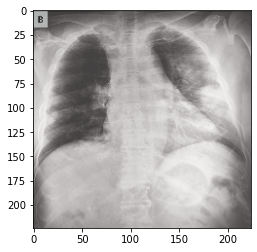

In [20]:
#PIC 9 PREDICTION
file_path = '/pic9.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

1/1 [==============================] - 0s 68ms/step
prediction:  Covid


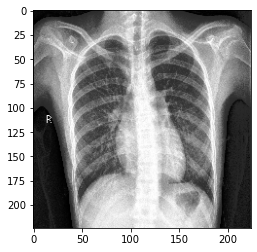

In [21]:
#PIC 10 PREDICTION
file_path = '/pic10.jpeg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)